### Trying to create a model for county by county data for Wisconsin.
- Used the combined data from 2018-19 to 2022-23.
- For 2018-19 academic year, used the population and income data for the year 2018, and so on.
- Income and population data retrieved from the CAINC1 data file released by bea.gov.
- The county ('Shawano') present in Wisconsin AP data but not in CAINC1 file has been manually retrieved (population from census.gov and income from federal reserve in St. Louis).
- Used geopy to compute the average distance between counties and university. We take the five closest universities to compute the average distance.
### Also did naïve modelling with statsmodels
- Percentage of 3 or above score (AKA pass rate) is used as the target variable.
- Per capita income, population and average distance to five closest R1R2, public, private (not for profit), stem and landgrant universities, as well as average enrollment in them are used as features.
- Full model includes all features.
- Uni metric model includes the 15 university related metrics as features.
- Non-uni model includes per capita and population as features.
- The p-values are all small. Might be reflective of the fact that none of the features are very accurate at predicting the pass rates, so adding more features makes some improvements to the models.
### Also did modelling with sklearn and xgboost
- Considered the ordinary least squares (OLS) linear regression (with aforementioned three types of models), PCA-then-linear-regression model (with n-components = 0.95) and Ridge model.
- The PCA reduced the 17 features to 9 when set n-components=0.95.
- Did 5-fold cross validation, and compared the average root mean square errors (rmse) of the models.
- Xgboost has the lowest average rmse, followed by Ridge and full model with sklearn.
- Also created the summary plots with shap.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [4]:
training = pd.read_csv('data/Wisconsin/train_test_split/training.csv')

In [5]:
training

,Unnamed: 0,COUNTY,STUDENTS_TESTED,EXAM_COUNT,EXAMS_3_OR_ABOVE,PERCENT_3_OR_ABOVE,Year,Latitude,Longitude,population,...,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem
0,124,Sauk,674,1046,612,58.508604,2019,43.4267,-89.9482,65586,...,28789.0,18208.8,2322.8,29555.6,22189.6,5812.6,2876.2,659.4,5587.6,4480.6
1,31,Lafayette,87,128,54,42.187500,2018,42.6605,-90.1317,16631,...,28789.0,16490.0,1105.8,40912.2,23072.4,5812.6,2271.8,580.6,8589.0,5085.2
2,93,Iowa,110,150,89,59.333333,2019,43.0005,-90.1354,23688,...,28789.0,16490.0,1801.8,29555.6,22189.6,5812.6,2271.8,514.8,5587.6,4480.6
3,113,Ozaukee,1675,3158,2398,75.934136,2019,43.3840,-87.9509,90998,...,27215.0,13718.0,2760.4,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4
4,183,Ozaukee,1603,3110,2143,68.906752,2020,43.3840,-87.9509,91613,...,27215.0,13718.0,2760.4,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,212,Barron,130,226,122,53.982301,2021,45.4237,-91.8483,46746,...,33726.6,8040.4,2396.0,13358.4,24446.6,7165.0,1452.2,718.8,1502.8,3910.4
275,204,Washington,1467,2457,1846,75.132275,2020,43.3685,-88.2307,136784,...,27215.0,13718.0,2207.4,30553.4,23576.2,5328.0,727.4,488.8,8082.0,4383.4
276,213,Bayfield,8,10,6,60.000000,2021,46.5237,-91.2009,16304,...,32768.4,4791.8,1589.6,13358.4,27023.8,5750.4,733.6,470.4,1502.8,5023.0
277,138,Winnebago,1012,1338,939,70.179372,2019,44.0689,-88.6446,171875,...,27064.0,12610.2,1996.4,9798.8,23576.2,5303.4,485.2,1057.8,1774.2,4383.4


In [6]:
columns = training.columns[1:]

In [7]:
training = training[columns]

In [8]:
features = list(training.columns[8:])
features

['population',
 'per_capita_income',
 'closest_five_r1r2_avg',
 'closest_five_public_avg',
 'closest_five_private_nfp_avg',
 'closest_five_landgrnt_avg',
 'closest_five_stem_avg',
 'closest_five_avg_enrollment_r1r2',
 'closest_five_avg_enrollment_public',
 'closest_five_avg_enrollment_private_nfp',
 'closest_five_avg_enrollment_landgrnt',
 'closest_five_avg_enrollment_stem',
 'closest_five_avg_dormrooms_r1r2',
 'closest_five_avg_dormrooms_public',
 'closest_five_avg_dormrooms_private_nfp',
 'closest_five_avg_dormrooms_landgrant',
 'closest_five_avg_dormrooms_stem']

### Some exploratory plots:

In [9]:
'''for feature in features:
    sns.lmplot(data = training, y='PERCENT_3_OR_ABOVE',x=feature)'''

"for feature in features:\n    sns.lmplot(data = training, y='PERCENT_3_OR_ABOVE',x=feature)"

### Let's do some statistical analysis with statsmodels

In [10]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [11]:
x_train = training.drop(['COUNTY','STUDENTS_TESTED','EXAM_COUNT','EXAMS_3_OR_ABOVE','PERCENT_3_OR_ABOVE','Year','Latitude','Longitude'],axis=1)
y_train = training[['PERCENT_3_OR_ABOVE']]
X_train = sm.add_constant(x_train)
unimetric_train = X_train.drop(['population','per_capita_income'],axis=1)
X_train

,const,population,per_capita_income,closest_five_r1r2_avg,closest_five_public_avg,closest_five_private_nfp_avg,closest_five_landgrnt_avg,closest_five_stem_avg,closest_five_avg_enrollment_r1r2,closest_five_avg_enrollment_public,closest_five_avg_enrollment_private_nfp,closest_five_avg_enrollment_landgrnt,closest_five_avg_enrollment_stem,closest_five_avg_dormrooms_r1r2,closest_five_avg_dormrooms_public,closest_five_avg_dormrooms_private_nfp,closest_five_avg_dormrooms_landgrant,closest_five_avg_dormrooms_stem
0,1.0,65586,52266,165.657277,79.050762,87.107569,241.077779,150.841269,28789.0,18208.8,2322.8,29555.6,22189.6,5812.6,2876.2,659.4,5587.6,4480.6
1,1.0,16631,42307,149.777499,59.774503,49.414130,265.933725,147.383482,28789.0,16490.0,1105.8,40912.2,23072.4,5812.6,2271.8,580.6,8589.0,5085.2
2,1.0,23688,49996,155.105400,59.472726,68.600648,256.012403,151.749264,28789.0,16490.0,1801.8,29555.6,22189.6,5812.6,2271.8,514.8,5587.6,4480.6
3,1.0,90998,83681,100.211662,43.374257,29.321344,237.854721,76.702890,27215.0,13718.0,2760.4,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4
4,1.0,91613,86875,100.211662,43.374257,29.321344,237.854721,76.702890,27215.0,13718.0,2760.4,30553.4,23576.2,5328.0,727.4,737.4,8082.0,4383.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,1.0,46746,56928,315.001573,56.850040,104.645890,180.023262,265.872638,33726.6,8040.4,2396.0,13358.4,24446.6,7165.0,1452.2,718.8,1502.8,3910.4
275,1.0,136784,61808,99.992900,43.885707,34.165428,242.505515,76.110717,27215.0,13718.0,2207.4,30553.4,23576.2,5328.0,727.4,488.8,8082.0,4383.4
276,1.0,16304,53818,349.980358,73.937033,142.596656,176.494830,316.183281,32768.4,4791.8,1589.6,13358.4,27023.8,5750.4,733.6,470.4,1502.8,5023.0
277,1.0,171875,48651,171.045198,42.659306,44.717736,226.369238,148.475619,27064.0,12610.2,1996.4,9798.8,23576.2,5303.4,485.2,1057.8,1774.2,4383.4


In [12]:
full_model = sm.OLS(y_train,X_train).fit()
unimetric_model = sm.OLS(y_train,unimetric_train).fit()
nonuni_model = smf.ols('PERCENT_3_OR_ABOVE ~ per_capita_income + population', data=training).fit()
unidistance_model = smf.ols('PERCENT_3_OR_ABOVE ~ closest_five_r1r2_avg + closest_five_public_avg + closest_five_private_nfp_avg + closest_five_landgrnt_avg + closest_five_stem_avg', data = training).fit()
pci_model=smf.ols('PERCENT_3_OR_ABOVE ~ per_capita_income', data =training).fit()

In [13]:
f_test_nonuni = full_model.compare_f_test(nonuni_model)
f_test_unimetric = full_model.compare_f_test(unimetric_model)
f_test_unidistance = unimetric_model.compare_f_test(unidistance_model)
print("p-value of full compared to non-university metric model:", f_test_nonuni[1])
print("p-value of full compared to university metric model:", f_test_unimetric[1])
print("p-value of university metric compared to university distance model:", f_test_unidistance[1])

p-value of full compared to non-university metric model: 3.731663573638362e-09
p-value of full compared to university metric model: 2.2652849024399297e-06
p-value of university metric compared to university distance model: 5.445215210755048e-10


### All three p-values are small, which is probably indicative of the fact that models are not as accurate as we would want, so adding more features makes decent improvements.

# Next, let's create some models with sklearn

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [15]:
uni_features = list(training.columns[10:])
nonuni_features = list(training.columns[8:10])
features_wo_dormrooms = list(training.columns[8:-5])
coordinates = ['Latitude','Longitude']
features_wo_dormrooms

['population',
 'per_capita_income',
 'closest_five_r1r2_avg',
 'closest_five_public_avg',
 'closest_five_private_nfp_avg',
 'closest_five_landgrnt_avg',
 'closest_five_stem_avg',
 'closest_five_avg_enrollment_r1r2',
 'closest_five_avg_enrollment_public',
 'closest_five_avg_enrollment_private_nfp',
 'closest_five_avg_enrollment_landgrnt',
 'closest_five_avg_enrollment_stem']

In [16]:
fullmodel = LinearRegression()
fullmodel.fit(training[features],training['PERCENT_3_OR_ABOVE'])

LinearRegression()

In [17]:
unimodel = LinearRegression()
unimodel.fit(training[uni_features],training['PERCENT_3_OR_ABOVE'])

LinearRegression()

In [18]:
nonunimodel = LinearRegression()
nonunimodel.fit(training[nonuni_features],training['PERCENT_3_OR_ABOVE'])

LinearRegression()

In [19]:
wodormrooms_model = LinearRegression()
wodormrooms_model.fit(training[features_wo_dormrooms],training['PERCENT_3_OR_ABOVE'])

LinearRegression()

In [20]:
fullmodel.intercept_

-35.0648160692762

In [21]:
fullmodel.coef_

array([ 1.02154169e-05,  4.74853413e-04, -1.54404005e-01, -2.77049576e-01,
        4.96136503e-02,  2.28154888e-01,  1.91871636e-01,  2.10550004e-03,
        4.95826700e-04,  1.03869552e-03, -6.13103290e-04, -5.61628410e-04,
       -1.47056614e-03, -6.10147098e-03, -2.08308442e-02,  5.86249747e-04,
        2.67840638e-03])

In [41]:
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

In [23]:
## import KFold and kNeighborsRegressor here
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor

In [24]:
num_splits = 5
num_models = 5
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the mse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    wisconsin_train = training.iloc[train_index]
    
    ## cv holdout set
    wisconsin_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the "take the mean and call it a day" model
    baseline_pred = wisconsin_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(wisconsin_holdout))
    
    rmses[0, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(wisconsin_train[features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(wisconsin_holdout[features]))
    
    
    ## Fit and get ho mse for nonuni model
    nonuni_lr = LinearRegression()
    
    nonuni_lr.fit(wisconsin_train[nonuni_features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[2, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], nonuni_lr.predict(wisconsin_holdout[nonuni_features]))
    
    ## Fit and get ho mse for uni model
    uni_lr = LinearRegression()

    uni_lr.fit(wisconsin_train[uni_features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], uni_lr.predict(wisconsin_holdout[uni_features]))

    ## Fit and get ho mse for no dorm rooms model

    nodorm_lr = LinearRegression()

    nodorm_lr.fit(wisconsin_train[features_wo_dormrooms],wisconsin_train['PERCENT_3_OR_ABOVE'])

    rmses[4, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], nodorm_lr.predict(wisconsin_holdout[features_wo_dormrooms]))

    i = i+1


In [25]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"nonuni model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"uni model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")
print(f"no dorm rooms model Avg. CV RMSE: {np.mean(rmses[4,:])} and STD: {np.std(rmses[4,:])}")

Baseline Avg. CV RMSE: 13.8952139409969 and STD: 1.0814455082287104
fullmodel Avg. CV RMSE: 11.932550600513991 and STD: 0.5525042295596725
nonuni model Avg. CV RMSE: 12.7917917484458 and STD: 0.83153691794454
uni model Avg. CV RMSE: 12.480347156741294 and STD: 0.8005245009285296
no dorm rooms model Avg. CV RMSE: 12.431236049953718 and STD: 0.6116809137587357


### Full model performs clearly the best. The "no dorm rooms" model is the second best, though uni model is not far behind. While nonuni model lags behind, the difference is still not that big.
### Of course, we should choose the fullmodel from this this quartet.

**Now, let's do some PCA**

In [26]:
scaler = StandardScaler()
training_scaled = scaler.fit_transform(training[features])
training_scaled.shape

(279, 17)

In [27]:
pca = PCA(0.95)
training_pca = pca.fit_transform(training_scaled)

In [28]:
training_pca.shape

(279, 9)

In [29]:
pca.explained_variance_ratio_

array([0.41194672, 0.20111255, 0.10427498, 0.07210831, 0.06168245,
       0.040438  , 0.03217378, 0.02520899, 0.01566555])

**PCA can reduce the number of features from 17 to 9, if we require n-components = 0.95**

### **Comparing PCA model and Ridge model and the full model**

In [30]:
pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('reg', LinearRegression())])
ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

In [31]:
pca_pipe.fit(training[features],training['PERCENT_3_OR_ABOVE'])
ridge_pipe.fit(training[features],training['PERCENT_3_OR_ABOVE'])

Pipeline(steps=[('scale', StandardScaler()), ('ridge', Ridge())])

In [39]:
ridge_pipe.score(training[features],training['PERCENT_3_OR_ABOVE'])

0.3388879754611607

In [40]:
pca_pipe.score(training[features],training['PERCENT_3_OR_ABOVE'])

0.22753791455622485

In [43]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))
rsquared = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    wisconsin_train = training.iloc[train_index]
    
    ## cv holdout set
    wisconsin_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model
    baseline_pred = wisconsin_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(wisconsin_holdout))
    
    rmses[0, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    rsquared[0, i] = r2_score(wisconsin_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(wisconsin_train[features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(wisconsin_holdout[features]))
    rsquared[1, i] = full_lr.score(wisconsin_holdout[features],wisconsin_holdout['PERCENT_3_OR_ABOVE'])
    
    ## Fit and get ho mse for PCA model
    pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA(0.95)), ('reg', LinearRegression())])
    
    pca_pipe.fit(wisconsin_train[features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[2, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], pca_pipe.predict(wisconsin_holdout[features]))
    rsquared[2, i] = pca_pipe.score(wisconsin_holdout[features],wisconsin_holdout['PERCENT_3_OR_ABOVE'])
    
    ## Fit and get ho mse for Ridge model
    ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

    ridge_pipe.fit(wisconsin_train[features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], ridge_pipe.predict(wisconsin_holdout[features]))
    rsquared[3, i] = ridge_pipe.score(wisconsin_holdout[features],wisconsin_holdout['PERCENT_3_OR_ABOVE'])

    i = i+1


In [33]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"PCA model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Ridge model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 13.8952139409969 and STD: 1.0814455082287104
fullmodel Avg. CV RMSE: 11.932550600513991 and STD: 0.5525042295596725
PCA model Avg. CV RMSE: 12.69751393720681 and STD: 0.8066810024461883
Ridge model Avg. CV RMSE: 11.897170135820051 and STD: 0.5995223899876664


### Ridge model yelds the lowest average RMSE, though full model is not far behind. Full model has lower standard deviation on the RMSE's though.

In [44]:
## Find the avg cv r-squared coefficients for each model here
print(f"Baseline Avg. CV R-squared: {np.mean(rsquared[0,:])} and STD: {np.std(rsquared[0,:])}")
print(f"fullmodel Avg. CV R-squared: {np.mean(rsquared[1,:])} and STD: {np.std(rsquared[1,:])}")
print(f"PCA model Avg. CV R-squared: {np.mean(rsquared[2,:])} and STD: {np.std(rsquared[2,:])}")
print(f"Ridge model Avg. CV R-squared: {np.mean(rsquared[3,:])} and STD: {np.std(rsquared[3,:])}")

Baseline Avg. CV R-squared: -0.029081278912817865 and STD: 0.03576008503798913
fullmodel Avg. CV R-squared: 0.2364879672176734 and STD: 0.05686487370531589
PCA model Avg. CV R-squared: 0.13716467736070584 and STD: 0.06349405276629938
Ridge model Avg. CV R-squared: 0.24186868624183283 and STD: 0.04827234121566738


### In terms of coefficient of determination as well, the Ridge model appears the best, but full model is not far behind.

# Let's create model using xgboost

In [70]:
import xgboost as xgb
xgb.__version__

'2.1.2'

In [71]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(training, test_size = 0.2, random_state = 226)

In [72]:
X_train = train[features]
y_train = train['PERCENT_3_OR_ABOVE']
X_test = validation[features]
y_test = validation['PERCENT_3_OR_ABOVE']

In [73]:
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test,y_test,enable_categorical=True)

In [74]:


params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
n = 1000

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
)

[0]	train-rmse:11.31673	validation-rmse:10.63973


[10]	train-rmse:3.25086	validation-rmse:9.52551
[20]	train-rmse:1.78601	validation-rmse:10.21327
[30]	train-rmse:1.13477	validation-rmse:10.26503
[40]	train-rmse:0.70844	validation-rmse:10.26203
[50]	train-rmse:0.50380	validation-rmse:10.25951
[60]	train-rmse:0.31230	validation-rmse:10.28440
[70]	train-rmse:0.22957	validation-rmse:10.29078
[80]	train-rmse:0.15494	validation-rmse:10.29641
[90]	train-rmse:0.10308	validation-rmse:10.30052
[100]	train-rmse:0.06781	validation-rmse:10.30036
[102]	train-rmse:0.06289	validation-rmse:10.29956


In [75]:
# Example: New data to predict
X_new = training[features].head(3)  ## just use the old data as a quick example

# Create a DMatrix for the new data
dnew_reg = xgb.DMatrix(X_new, enable_categorical=True)

# Make predictions
y_pred_new = xgb_model.predict(dnew_reg)

print('Predictions for new percentage of AP outcomes that scores 3-5:')
print(y_pred_new)

Predictions for new percentage of AP outcomes that scores 3-5:
[58.52509 42.20006 59.37463]


In [76]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=100
)

results.head()


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,11.286491,0.411170,12.702540,1.420145
1,9.136603,0.251342,11.967372,1.136993
2,7.623404,0.156434,11.684826,0.894607
3,6.415809,0.142172,11.503246,0.887942
4,5.481073,0.241379,11.362735,0.758724


In [77]:
mean_train_rmse = results['train-rmse-mean'].iloc[-1]  # Final mean train RMSE
std_train_rmse = results['train-rmse-std'].iloc[-1]    # Final std dev train RMSE

mean_val_rmse = results['test-rmse-mean'].iloc[-1]     # Final mean validation RMSE
std_val_rmse = results['test-rmse-std'].iloc[-1]       # Final std dev validation RMSE

# Print results
print(f"Training RMSE: {mean_train_rmse:.4f} +/- {std_train_rmse:.4f}")
print(f"Validation RMSE: {mean_val_rmse:.4f} +/- {std_val_rmse:.4f}")

Training RMSE: 5.4811 +/- 0.2414
Validation RMSE: 11.3627 +/- 0.7587


In [78]:
num_splits = 5
num_models = 4
kfold = KFold(num_splits,
              random_state = 226,
              shuffle=True)
## This array will hold the rmse for each model and split
rmses = np.zeros((num_models, num_splits))

## sets a split counter
i = 0

## loop through the kfold here
for train_index, test_index in kfold.split(training):
    ## cv training set
    wisconsin_train = training.iloc[train_index]
    
    ## cv holdout set
    wisconsin_holdout = training.iloc[test_index]
    
    ## "Fit" and get ho mse for the baseline model
    baseline_pred = wisconsin_train['PERCENT_3_OR_ABOVE'].mean()*np.ones(len(wisconsin_holdout))
    
    rmses[0, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], baseline_pred)
    
    ## Fit and get ho mse for full model
    full_lr = LinearRegression()
    
    full_lr.fit(wisconsin_train[features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[1, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], full_lr.predict(wisconsin_holdout[features]))
    
    
    ## Fit and get ho mse for xgboost model
    
    dtrain_reg = xgb.DMatrix(wisconsin_train[features], wisconsin_train['PERCENT_3_OR_ABOVE'], enable_categorical=True)
    dtest_reg = xgb.DMatrix(wisconsin_holdout[features],wisconsin_holdout['PERCENT_3_OR_ABOVE'],enable_categorical=True)

    params = {"objective": "reg:squarederror", "tree_method": "hist"}   ## "hist" uses cpu to compute the model
    n = 1000

    evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

    xgb_model = xgb.train(
    params=params,
    dtrain=dtrain_reg,
    num_boost_round=n,
    evals=evals,
    verbose_eval=10,            # Print rmse val every 10 rounds
    early_stopping_rounds=100   # XGBoost will automatically stop the training if validation loss doesn't improve for 100 consecutive rounds
    )

    y_pred = xgb_model.predict(dtest_reg)
    rmses[2,i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'],y_pred)
    
    ## Fit and get ho mse for Ridge model
    ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', Ridge())])

    ridge_pipe.fit(wisconsin_train[features],wisconsin_train['PERCENT_3_OR_ABOVE'])
    
    rmses[3, i] = root_mean_squared_error(wisconsin_holdout['PERCENT_3_OR_ABOVE'], ridge_pipe.predict(wisconsin_holdout[features]))

    i = i+1


[0]	train-rmse:11.31673	validation-rmse:10.63973
[10]	train-rmse:3.25086	validation-rmse:9.52551
[20]	train-rmse:1.78601	validation-rmse:10.21327
[30]	train-rmse:1.13477	validation-rmse:10.26503
[40]	train-rmse:0.70844	validation-rmse:10.26203
[50]	train-rmse:0.50380	validation-rmse:10.25951
[60]	train-rmse:0.31230	validation-rmse:10.28440
[70]	train-rmse:0.22957	validation-rmse:10.29078
[80]	train-rmse:0.15494	validation-rmse:10.29641
[90]	train-rmse:0.10308	validation-rmse:10.30052
[100]	train-rmse:0.06781	validation-rmse:10.30036
[103]	train-rmse:0.06041	validation-rmse:10.30010
[0]	train-rmse:11.28603	validation-rmse:11.23652
[10]	train-rmse:2.99381	validation-rmse:8.70205
[20]	train-rmse:1.78769	validation-rmse:8.73008
[30]	train-rmse:1.23319	validation-rmse:8.76706
[40]	train-rmse:0.76011	validation-rmse:8.79996
[50]	train-rmse:0.56375	validation-rmse:8.75255
[60]	train-rmse:0.32361	validation-rmse:8.76433
[70]	train-rmse:0.21289	validation-rmse:8.78233
[80]	train-rmse:0.13390	va

In [79]:
## Find the avg cv mse for each model here
print(f"Baseline Avg. CV RMSE: {np.mean(rmses[0,:])} and STD: {np.std(rmses[0,:])}")
print(f"fullmodel Avg. CV RMSE: {np.mean(rmses[1,:])} and STD: {np.std(rmses[1,:])}")
print(f"xgboost model Avg. CV RMSE: {np.mean(rmses[2,:])} and STD: {np.std(rmses[2,:])}")
print(f"Ridge model Avg. CV RMSE: {np.mean(rmses[3,:])} and STD: {np.std(rmses[3,:])}")

Baseline Avg. CV RMSE: 13.8952139409969 and STD: 1.0814455082287104
fullmodel Avg. CV RMSE: 11.932550600513991 and STD: 0.5525042295596725
xgboost model Avg. CV RMSE: 10.375916506550167 and STD: 1.355299784057582
Ridge model Avg. CV RMSE: 11.897170135820051 and STD: 0.5995223899876664


### Xgboost model has clearly the lowest average 5-fold cross validation RMSE, but the standard deviation is also quite high. Nonetheless, it is probably the best to still choose the xgboost model.

### Comparing RMSE's on 5-Fold cross-validation of various models:
- "Take average and call it a day" model: 13.8952139409969
- OLS full model (sklearn): 11.932550600513991
- Ridge model (sklearn): 11.897170135820051
- PCA(0.95) model (sklearn): 12.69751393720681
- Xgboost model with full features: 10.375916506550167

# Let's use SHAP to explain our xgboost model.

In [42]:
import shap

In [43]:
#explainer = shap.Explainer(fullmodel,training[features])
#shap_values = explainer(training[features])
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

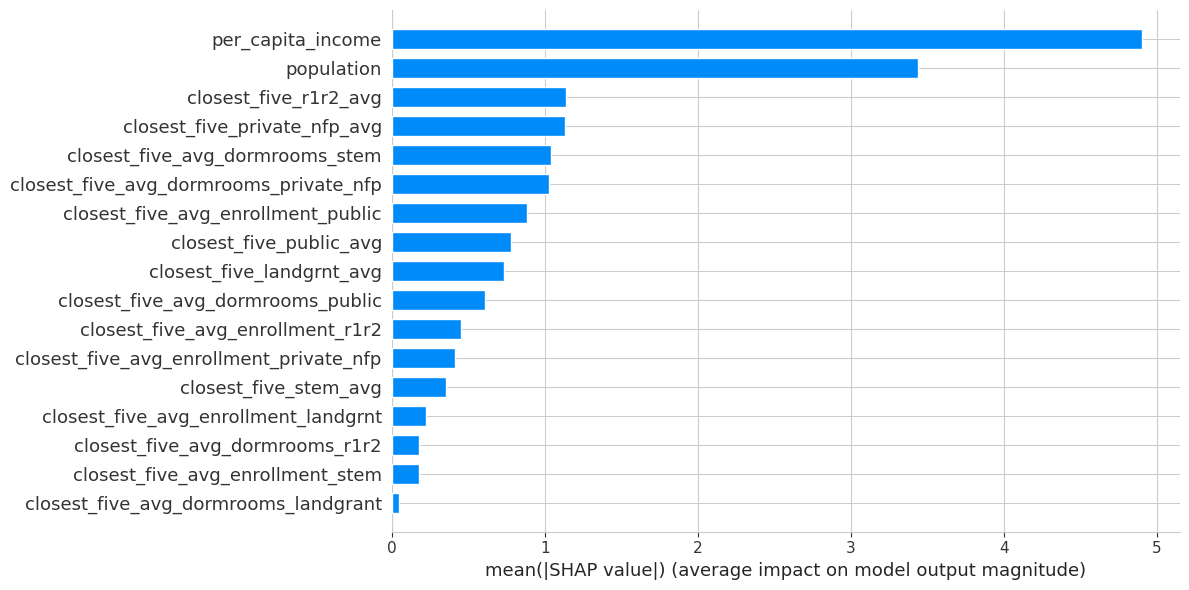

In [44]:
shap.summary_plot(
    shap_values, 
    X_train, 
    plot_type='bar', 
    show=False,
    plot_size=[12, 6]
)
plt.show()
plt.close()

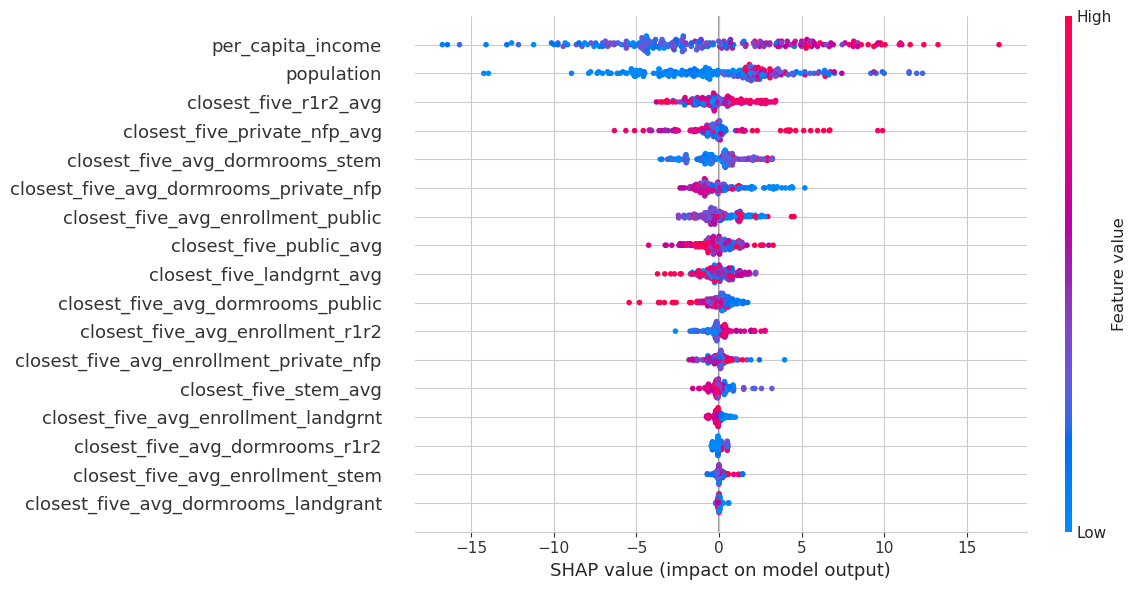

In [45]:
### the scatter plot
shap.summary_plot(shap_values, X_train, show=False, plot_size=[12, 6])
plt.show()
plt.close()